# ANOVOS - Data Drift and Stability Index
Following notebook shows the list of "data drift and stability" related functions supported under ANOVOS package and how it can be invoked accordingly
- [Data Drift Statistics](#Data-Drift-Statistics)
- [Attribute Stability Index](#Data-Stability-Index)
- [Feature Stability Estimation](#Feature-Stability-Estimation)
- [Appendix: Attribute Stability Index Result Visualization](#Appendix:-Attribute-Stability-Index-Result-Visualization)

**Setting up Spark Session**

In [1]:
#set run type variable
run_type = "local" # "local", "emr", "databricks", "ak8s"

In [2]:
#For run_type Azure Kubernetes, run the following block 
import os
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

if run_type == "ak8s":
    fs_path="<insert conf spark.hadoop.fs master url here> ex: spark.hadoop.fs.azure.sas.<container>.<account_name>.blob.core.windows.net"
    auth_key="<insert value of sas_token here>"
    master_url="<insert kubernetes master url path here> ex: k8s://"
    docker_image="<insert name docker image here>"
    kubernetes_namespace ="<insert kubernetes namespace here>"

    # Create Spark config for our Kubernetes based cluster manager
    sparkConf = SparkConf()
    sparkConf.setMaster(master_url)
    sparkConf.setAppName("Anovos_pipeline")
    sparkConf.set("spark.submit.deployMode","client")
    sparkConf.set("spark.kubernetes.container.image", docker_image)
    sparkConf.set("spark.kubernetes.namespace", kubernetes_namespace)
    sparkConf.set("spark.executor.instances", "4")
    sparkConf.set("spark.executor.cores", "4")
    sparkConf.set("spark.executor.memory", "16g")
    sparkConf.set("spark.kubernetes.pyspark.pythonVersion", "3")
    sparkConf.set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
    sparkConf.set(fs_path,auth_key)
    sparkConf.set("spark.kubernetes.authenticate.serviceAccountName", "spark")
    sparkConf.set("spark.jars.packages", "org.apache.hadoop:hadoop-azure:3.2.0,com.microsoft.azure:azure-storage:8.6.3,io.github.histogrammar:histogrammar_2.12:1.0.20,io.github.histogrammar:histogrammar-sparksql_2.12:1.0.20,org.apache.spark:spark-avro_2.12:3.2.1")

    # Initialize our Spark cluster, this will actually
    # generate the worker nodes.
    spark = SparkSession.builder.config(conf=sparkConf).getOrCreate()
    sc = spark.sparkContext

#For other run types import from anovos.shared.
else:
    from anovos.shared.spark import *
    auth_key = "NA"

2022-11-16 14:07:48.288 | INFO     | anovos.shared.spark:init_spark:54 - Getting spark session, context and sql context app_name: Anovos_pipeline


In [3]:
sc.setLogLevel("ERROR")
import warnings
warnings.filterwarnings('ignore')

**Input/Output Path** 

In [4]:
driftTargetPath = '../data/income_dataset/csv'
driftSourcePath = '../data/income_dataset/source'
stabilityPath = '../data/income_dataset/stability_index/'
outputPath = "../output/income_dataset/data_drift/"

## Data Drift Statistics
- API specification of function **statistics** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>
- Supports 5 different ways of computing the drift statistics between target and source datasets.

In [5]:
from anovos.drift_stability.drift_detector import statistics

In [6]:
# Read source and target datasets
from anovos.data_ingest.data_ingest import read_dataset
target_df = read_dataset(spark, driftTargetPath,"csv", {'header':True,'inferSchema':True}).drop("dt_1", "dt_2")
source_df = read_dataset(spark, driftSourcePath,"csv", {'header':True,'inferSchema':True}).drop("dt_1", "dt_2")

In [7]:
# Example 1 - all columns + drift metric PSI
result_PSI = statistics(spark, target_df, source_df)
result_PSI.toPandas()

2022-11-16 14:08:01.531 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


,attribute,PSI,flagged
0,capital-gain,0.000000,0
1,logfnl,0.000000,0
2,hours-per-week,0.000000,0
3,fnlwgt,0.000000,0
4,education-num,0.000000,0
5,latitude,0.000000,0
6,ifa,0.000000,0
7,income,0.000000,0
8,education,0.000000,0
9,empty,0.000000,0


In [8]:
# Example 2 - selected columns + drift metric PSI
result_PSI = statistics(spark, target_df, source_df, 
                        list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'],
                        threshold=0.1)
result_PSI.toPandas()

2022-11-16 14:08:32.820 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


,attribute,PSI,flagged
0,age,0.0,0
1,hours-per-week,0.0,0
2,capital-gain,0.0,0
3,education-num,0.0,0


In [9]:
# Example 3 - selected columns + compute statistics of JSD, HD and KS with a different bin_size
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           method_type=['JSD','HD','KS'], bin_size=100)
result_others.toPandas()

2022-11-16 14:08:38.192 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


,attribute,HD,JSD,KS,flagged
0,age,0.0,0.0,0.0,0
1,hours-per-week,0.0,0.0,0.0,0
2,capital-gain,0.0,0.0,0.0,0
3,education-num,0.0,0.0,0.0,0


In [10]:
# Example 4 - selected columns + save model
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           pre_existing_source=False, source_path=outputPath)
result_others.toPandas()

2022-11-16 14:08:45.779 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


,attribute,PSI,flagged
0,age,0.0,0
1,hours-per-week,0.0,0
2,capital-gain,0.0,0
3,education-num,0.0,0


In [11]:
# Example 5 - selected columns + use pre-saved model
result_others = statistics(spark, target_df, source_df, 
                           list_of_cols=['age', 'education-num', 'capital-gain', 'hours-per-week'], 
                           pre_existing_source=True, source_path=outputPath)
result_others.toPandas()

2022-11-16 14:08:50.757 | DEBUG    | anovos.drift_stability.validations:validate:20 - check the list of columns


,attribute,PSI,flagged
0,age,0.0,0
1,hours-per-week,0.0,0
2,capital-gain,0.0,0
3,education-num,0.0,0


## Data Stability Index 
- API specification of function **stability_index_computation** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>

In [12]:
from anovos.drift_stability.stability import stability_index_computation

In [13]:
# Read input datasets
df1 = read_dataset(spark, stabilityPath+"0","csv",{'header':True,'inferSchema':True})
df2 = read_dataset(spark, stabilityPath+"1","csv",{'header':True,'inferSchema':True})
df3 = read_dataset(spark, stabilityPath+"2","csv",{'header':True,'inferSchema':True})
df4 = read_dataset(spark, stabilityPath+"3","csv",{'header':True,'inferSchema':True})
df5 = read_dataset(spark, stabilityPath+"4","csv",{'header':True,'inferSchema':True})
df6 = read_dataset(spark, stabilityPath+"5","csv",{'header':True,'inferSchema':True})
df7 = read_dataset(spark, stabilityPath+"6","csv",{'header':True,'inferSchema':True})
df8 = read_dataset(spark, stabilityPath+"7","csv",{'header':True,'inferSchema':True})
df9 = read_dataset(spark, stabilityPath+"8","csv",{'header':True,'inferSchema':True})
df10 = read_dataset(spark, stabilityPath+"9","csv",{'header':True,'inferSchema':True})
df11 = read_dataset(spark, stabilityPath+"10","csv",{'header':True,'inferSchema':True})
df12 = read_dataset(spark, stabilityPath+"11","csv",{'header':True,'inferSchema':True})

In [14]:
df1.toPandas().head(5)

,ifa,age,fnlwgt,logfnl,education_num,capital_gain,capital_loss,hours_per_week,income_label,gender_label
0,27a,19,168294,5.226069,9,0,0,40,0,0
1,32a,20,266015,5.424906,10,0,0,44,0,0
2,38a,19,544091,5.735672,9,0,0,25,0,1
3,52a,18,226956,5.355942,9,0,0,30,0,1
4,71a,19,101509,5.006505,10,0,0,32,0,0


In [16]:
# Example 1 - input only one dataset
df_stability = stability_index_computation(spark, [df1], appended_metric_path=outputPath+'historical_metric_1')
df_stability.toPandas() # result: should be all NaN because there is only one dataset

,attribute,type,mean_stddev,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,income_label,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,fnlwgt,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,hours_per_week,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,capital_loss,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,logfnl,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,age,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,capital_gain,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,gender_label,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,education_num,Numerical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [17]:
# Read saved intermediate statistics in Example 1
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

,idx,attribute,type,mean,stddev,kurtosis
0,1,income_label,Numerical,0.001096,0.033113,910.001098
1,1,fnlwgt,Numerical,199011.575658,112956.123267,5.508391
2,1,hours_per_week,Numerical,29.103070,12.360231,3.088445
3,1,capital_loss,Numerical,40.483553,265.644311,44.091347
4,1,logfnl,Numerical,5.217221,0.291681,3.554139
5,1,age,Numerical,18.835526,1.053627,1.924572
6,1,capital_gain,Numerical,143.787281,1965.965077,293.243575
7,1,gender_label,Numerical,0.476974,0.499744,1.008501
8,1,education_num,Numerical,8.663377,1.620281,3.873733


In [18]:
# Example 2 - input a few more datasets and append to existing result + nondefault threshold
df_stability = stability_index_computation(spark, [df2,df3,df4,df5], 
                                           existing_metric_path=outputPath+'historical_metric_1', 
                                           appended_metric_path=outputPath+'historical_metric_1to5',threshold=2)
df_stability.toPandas()

,attribute,type,mean_stddev,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,income_label,Numerical,0.0935,0.9923,0.6478,2.0517,0.0,0.0,0.0,NaN,1
1,fnlwgt,Numerical,3876.2133,0.0196,0.0237,0.3066,4.0,4.0,1.0,3.4,0
2,hours_per_week,Numerical,5.6648,0.1482,0.0981,0.2924,2.0,3.0,1.0,2.1,0
3,capital_loss,Numerical,21.8488,0.3553,0.1801,0.3971,1.0,2.0,1.0,1.3,1
4,logfnl,Numerical,0.0092,0.0018,0.0357,0.0577,4.0,3.0,3.0,3.5,0
5,age,Numerical,5.1861,0.2019,0.1458,0.1307,1.0,2.0,2.0,1.5,1
6,capital_gain,Numerical,355.7109,0.6522,0.4582,0.4362,0.0,1.0,1.0,NaN,1
7,gender_label,Numerical,0.0711,0.1880,0.0354,0.2306,2.0,3.0,1.0,2.1,0
8,education_num,Numerical,0.6652,0.0677,0.1656,0.1097,3.0,2.0,2.0,2.5,0


In [19]:
# Example 3 - input rest of the datasets and append to previous results + nondefault threshold
df_stability = stability_index_computation(spark, [df6, df7, df8, df9, df10, df11, df12], 
                                           existing_metric_path=outputPath+'historical_metric_1to5', 
                                           appended_metric_path=outputPath+'historical_metric_1to12',threshold=2)
df_stability.toPandas()

,attribute,type,mean_stddev,mean_cv,stddev_cv,kurtosis_cv,mean_si,stddev_si,kurtosis_si,stability_index,flagged
0,income_label,Numerical,0.1441,0.6096,0.4039,3.1767,0.0,1.0,0.0,NaN,1
1,fnlwgt,Numerical,8948.2237,0.0470,0.0651,0.3067,3.0,3.0,1.0,2.6,0
2,hours_per_week,Numerical,4.7989,0.1191,0.1341,0.2292,2.0,2.0,1.0,1.8,1
3,capital_loss,Numerical,30.3291,0.3404,0.1929,0.4650,1.0,2.0,1.0,1.3,1
4,logfnl,Numerical,0.0191,0.0037,0.0379,0.0455,4.0,3.0,3.0,3.5,0
5,age,Numerical,14.0654,0.3669,0.8375,0.2110,1.0,0.0,1.0,NaN,1
6,capital_gain,Numerical,546.9481,0.5214,0.3517,0.5831,0.0,1.0,0.0,NaN,1
7,gender_label,Numerical,0.0611,0.1854,0.0361,0.1963,2.0,3.0,2.0,2.3,0
8,education_num,Numerical,0.5577,0.0555,0.1601,0.1305,3.0,2.0,2.0,2.5,0


In [20]:
# Read saved intermediate statistics in Example 3
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})
df_intermediate.toPandas()

,idx,attribute,type,mean,stddev,kurtosis
0,1,income_label,Numerical,0.001096,0.033113,910.001098
1,1,fnlwgt,Numerical,199011.575658,112956.123267,5.508391
2,1,hours_per_week,Numerical,29.103070,12.360231,3.088445
3,1,capital_loss,Numerical,40.483553,265.644311,44.091347
4,1,logfnl,Numerical,5.217221,0.291681,3.554139
...,...,...,...,...,...,...
103,9,logfnl,Numerical,5.208817,0.263958,3.860061
104,9,age,Numerical,45.533753,1.116818,1.646303
105,9,capital_gain,Numerical,1651.200720,9424.539583,96.513967
106,9,gender_label,Numerical,0.287129,0.452626,1.885536


## Feature Stability Estimation
- API specification of function **feature_stability_estimation** can be found <a href="https://docs.anovos.ai/api/drift/detector.html">here</a>

In [21]:
from anovos.drift_stability.stability import feature_stability_estimation

In [22]:
# Example 1: estimate stability for 3 new features
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'})
odf.toPandas()

,feature_formula,mean_cv,stddev_cv,mean_si,stddev_si,stability_index_lower_bound,stability_index_upper_bound,flagged_lower,flagged_upper
0,capital_gain/hours_per_week,0.4908,0.2920,1,1,0.8,1.6,1,0
1,capital_gain-capital_loss,0.5198,0.3359,0,1,0.3,1.1,1,0
2,age**2,0.6887,1.2766,0,0,0.0,0.8,1,1


In [23]:
# Example 2: estimate stability for 3 new features + nondefault metric_weightages
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'},
                                   metric_weightages={"mean": 0.7, "stddev": 0.3, "kurtosis": 0})
odf.toPandas()

,feature_formula,mean_cv,stddev_cv,mean_si,stddev_si,stability_index_lower_bound,stability_index_upper_bound,flagged_lower,flagged_upper
0,capital_gain/hours_per_week,0.4908,0.2920,1,1,1.0,1.0,0,0
1,capital_gain-capital_loss,0.5198,0.3359,0,1,0.3,0.3,1,1
2,age**2,0.6887,1.2766,0,0,0.0,0.0,1,1


In [24]:
# Example 3: estimate stability for 3 new features + nondefault threshold
odf = feature_stability_estimation(spark, df_intermediate, 
                                   {'capital_gain|hours_per_week': 'capital_gain/hours_per_week',
                                    'capital_gain|capital_loss': 'capital_gain-capital_loss',
                                    'age': 'age**2'}, threshold=2)
odf.toPandas()

,feature_formula,mean_cv,stddev_cv,mean_si,stddev_si,stability_index_lower_bound,stability_index_upper_bound,flagged_lower,flagged_upper
0,capital_gain/hours_per_week,0.4908,0.2920,1,1,0.8,1.6,1,1
1,capital_gain-capital_loss,0.5198,0.3359,0,1,0.3,1.1,1,1
2,age**2,0.6887,1.2766,0,0,0.0,0.8,1,1


## Appendix: Attribute Stability Index Result Visualization
The following function (not included in the module) can be used to visualise the trend of each metric for an attribute.

In [25]:
def plot_attribute_result(attribute_name, df_stability_result, df_intermediate,  
                          metric_weightages={'mean':0.5,'stddev':0.3,'kurtosis':0.2}):
    """
    :params attribute_name: name of the attribute
    :params df_stability_result: output of stabilityIndex_computation
    :params df_intermediate: intermediate output of stabilityIndex_computation
    :params metric_weightages: same metric weightages used in stabilityIndex_computation
    """
    from pyspark.sql import functions as F
    metric_si_df = df_stability_result.where(F.col('attribute')==attribute_name).select('mean_si', 'stddev_si', 'kurtosis_si', 'stability_index').take(1)
    metric_si = {}
    metric_si['mean'] = metric_si_df[0]['mean_si']
    metric_si['stddev'] = metric_si_df[0]['stddev_si']
    metric_si['kurtosis'] = metric_si_df[0]['kurtosis_si']
    attribute_si = metric_si_df[0]['stability_index']
    
    metric_stats = {}
    metric_stats['mean'] = df_intermediate.where(F.col('attribute')==attribute_name).select('mean').rdd.flatMap(lambda x: x).collect()
    metric_stats['stddev'] = df_intermediate.where(F.col('attribute')==attribute_name).select('stddev').rdd.flatMap(lambda x: x).collect()
    metric_stats['kurtosis'] = df_intermediate.where(F.col('attribute')==attribute_name).select('kurtosis').rdd.flatMap(lambda x: x).collect()
    
    import matplotlib.pyplot as plt
    import math
    metrics = list(metric_weightages.keys())

    figure, axis = plt.subplots(1, len(metrics), figsize=(5*len(metrics),4))
    figure.suptitle('{}:Final Attribute Stability={}'.format(attribute_name, attribute_si))
    for i, metric in enumerate(metrics):
        metric_stability = metric_si[metric]
        metric_weightage = metric_weightages[metric]
        y = metric_stats[metric]
        axis[i].plot(list(range(1, len(y)+1)), y)
        axis[i].set_title('{}: Stability={}, Weightage={}'.format(metric, metric_stability, metric_weightage))

In [26]:
df_intermediate = read_dataset(spark, outputPath+"historical_metric_1to12","csv",{'header':True,'inferSchema':True})

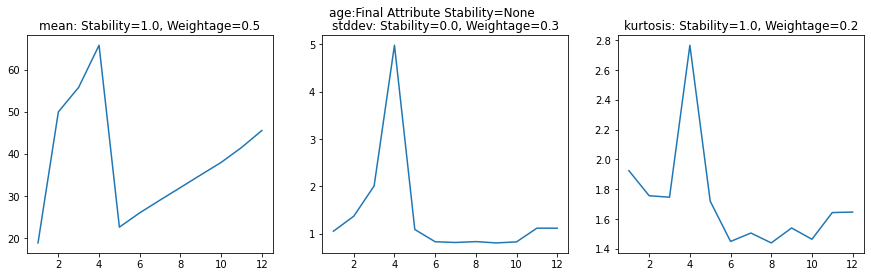

In [27]:
# Example 1 - attribute age
plot_attribute_result('age', df_stability, df_intermediate)

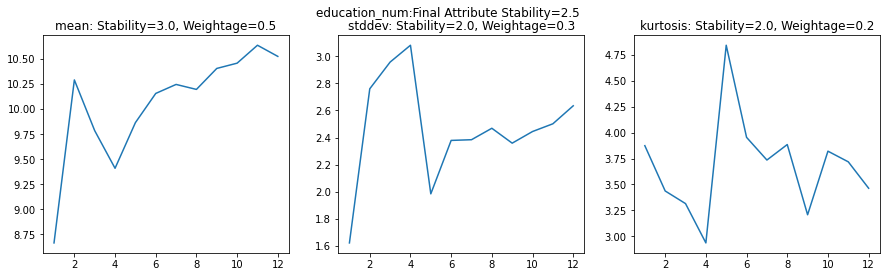

In [28]:
# Example 2 - attribute education_num
plot_attribute_result('education_num', df_stability, df_intermediate)

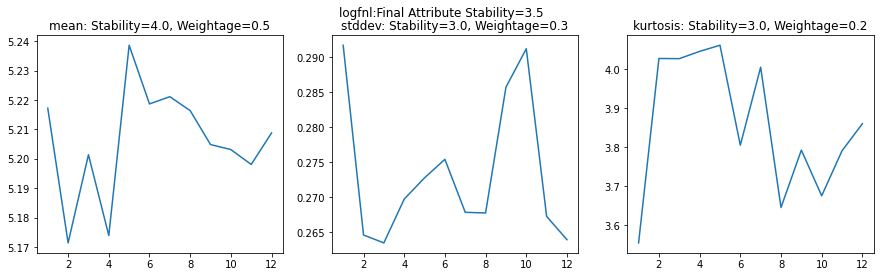

In [29]:
# Example 3 - attribute logfnl
plot_attribute_result('logfnl', df_stability, df_intermediate)